# Regularized Linear Regression and Bias vs Variance

Regularized linear regression will be implemented to predict the amount of water flowing out of a dam using the change of water level in a reservoir. 

#### Dataset: ex5data1.mat. 
This data is taken from the 'Machine learning course by Stanford University, coursera'. The dataset is non-linear, so we might encounter the problem of either high Bias or Variance. This notebook is dedicated to study the effects of bias/variance on the prediction, examine the learning algorithm by applying several diagonistics. 

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Loading the Dataset

This dataset is divided into three parts:
  
A training set that the model will learn on: X, y  
A cross validation set for determining the regularization parameter: Xval, yval  
A test set for evaluating performance : Xtest, ytest  
  
Load the dataset using scipy.io and visualizing the dataset containing historical records on the change in the water level, X, and the amount of water flowing out of the dam, y.

In [3]:
data = sio.loadmat('ex5data1.mat')

In [4]:
X = data.get('X') #Training sets
y = data.get('y')
Xval = data.get('Xval') #crossvalidation sets
yval = data.get('yval')
Xtest = data.get('Xtest')# Testing sets
ytest = data.get('ytest')

In [5]:
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12, 1), (12, 1), (21, 1), (21, 1), (21, 1), (21, 1))

Text(0, 0.5, 'Water flowing out of the dam (y)')

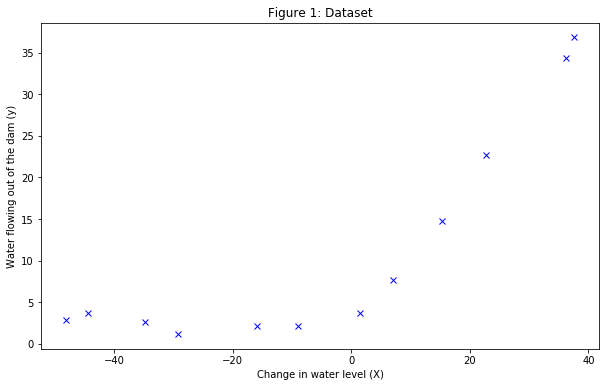

In [6]:
# plotting the data
plt.figure(figsize = (10,6))
plt.plot(X, y, 'bx')
plt.title('Figure 1: Dataset')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')

### Training a Linear Model

Now that the data is visualized, its clear from Figure 1, that we have a non-linear relation between X and y. Lets train the model using linear regression (with regularization) and check if the hypothesis fits the dataset well.

We will need to implement the cost,gradient functions before we train the model using scipy.optimize

In [7]:
def linearRegCostFunction(X, y, theta, regParam):
    """
    since lambda is a builtin function, lets use regParam short for regularization parameter for lambda.
    
    Input:
    X : (m,n+1)
    y : (m,1)
    theta: (n+1,1)
    
    Output:
    J : Cost function
    grad: Gradients
    
    """ 
    m = X.shape[0] #number of training examples
    theta = theta.reshape(-1,y.shape[1]) 
    
    hyp = np.dot(X, theta) # hypothesis
    error = hyp - y
    # we should not penalize theta_0.
    J = (1.0/(2.0 * m)) * np.sum(np.power(error,2)) + (regParam * np.sum(np.power(theta[1:],2))/(2.0 * m))
    
    grad = np.zeros(theta.shape)
    # compute gradient for all theta
    
    grad = (1.0/m) * np.dot(X.T, error) + (regParam * theta / m) # with regularization
    grad_wor = (1.0/m) * np.dot(X.T, error) #gradient without regularization
 
    grad[0] = grad_wor[0]
    
    return J,grad.flatten()

In [8]:
# Let's check if our gradient function works or not.
# Initialize theta = [1,1] and compute the cost, gradient.

X_1 = np.insert(X, 0, values = np.ones(X.shape[0]),axis = 1)
Xval_1 = np.insert(Xval, 0, values = np.ones(Xval.shape[0]),axis = 1)

theta = np.array([[1],[1]])

J, grad = linearRegCostFunction(X_1, y, theta, 1)

In [9]:
print('Cost: {}, gradient: {} for theta = (1,1)'.format(J,grad))

Cost: 303.9931922202643, gradient: [-15.30301567 598.25074417] for theta = (1,1)


In [10]:
# lets train the model
from scipy.optimize import minimize

In [11]:
def trainLinearRegression(X, y, regParam):
    # This function trains linear regression given a dataset (X, y) and a regularization parameter (regParam)
    
    initial_theta = np.zeros((X.shape[1],1))
    
    def costFunction(theta):
        return linearRegCostFunction(X, y, theta, regParam)
    
    # lets minimize the cost for initial theta!!
    results = minimize(fun=costFunction,
                       x0=initial_theta,
                       method='CG',
                       jac=True,
                       options={'maxiter':200})
    
    return results.x # theta for which the cost function is minimized

In [12]:
# Train the model
theta = trainLinearRegression(X_1, y, 0)
theta

array([13.08790351,  0.36777923])

For theta: [13.08790351,  0.36777923], the cost function is minimized. Lets plot the hypothesis and check if this fits the dataset properly.

Text(0, 0.5, 'Water flowing out of the dam (y)')

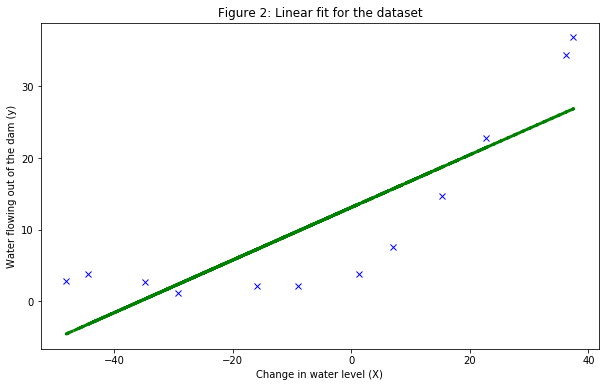

In [13]:
plt.figure(figsize = (10,6))
plt.plot(X, y, 'bx')
plt.plot(X, np.dot(X_1, theta), ls = '--',lw = 3, color='green')
plt.title('Figure 2: Linear fit for the dataset')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')

So it's clear from Figure 2, that the hypothesis doesn't fit the dataset very well. From the looks of the plot, we have an 'underfitting' problem.
But lets evaluate this by plotting the training and test errors on a learning curve to diagnose bias-variance problems.

### Bias- Variance Diagnosis

A learning curve plots training and cross validation error as a function of training set size. The code in learningCurve will return a vector of errors for the training set and cross validation set. The 'trainLinearRegression' function can be used to find the θ parameters for a subset of training examples. After learning the θ parameters, the error on the training and cross validation sets will be computed. Training and cross validation error does not include the regularization term.

In [14]:
def learningCurve(X, y, Xval, yval, regParam):
    """
    This function returns the train and cross validation set errors for a learning curve. 
    In particular, it returns two vectors of the same length - error_train and error_val. 
    Then, error_train(i) contains the training error for i examples (and similarly for error_val(i)).

    This function computes the train and test errors for dataset sizes from 1 up to m. 
    In practice, when working with larger datasets, you might want to do this in larger intervals.
    """
    
    m = X.shape[0]
    
    error_train = np.zeros((m,1))
    error_val = np.zeros((m,1))
    
    for i in range(1,m+1):
        #Train the model with different subsets of the training examples
        theta = trainLinearRegression(X[:i],y[:i],regParam)
        
        # compute the training and cross validation errors, with regParam = 0.
        error_train[i-1] = linearRegCostFunction(X[:i], y[:i], theta, 0)[0]
        error_val[i-1] = linearRegCostFunction(Xval, yval, theta, 0)[0]
    return error_train, error_val

In [15]:
regParam = 0.01
error_train, error_val = learningCurve(X_1,y,Xval_1,yval,regParam)

In [16]:
print('# Training Examples\tTrain Error\t\tCross Validation Error\n')
for i in range(X.shape[0]):
    print('{}\t\t\t{:f}\t\t{:f}\t\t\t\n'.format(i, float(error_train[i]), float(error_val[i])))

# Training Examples	Train Error		Cross Validation Error

0			0.000000		138.846777			

1			0.000000		110.303874			

2			3.286595		45.009849			

3			2.842678		48.368612			

4			13.154049		35.865075			

5			19.443963		33.829884			

6			20.098522		31.970932			

7			18.172859		30.862408			

8			22.609405		31.135966			

9			23.261462		28.936197			

10			24.317250		29.551428			

11			22.373906		29.433812			



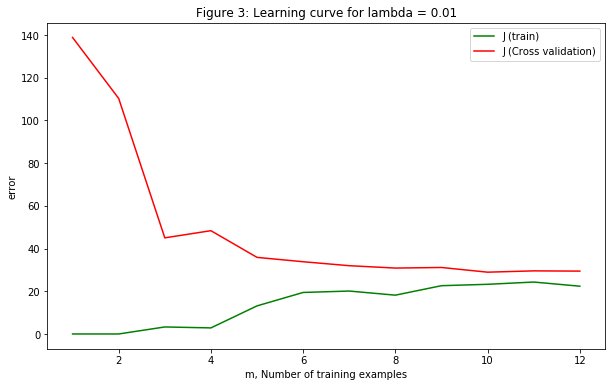

In [17]:
# Lets plot this!
plt.figure(figsize = (10,6))
plt.plot(range(1,X.shape[0]+1), error_train, 'g', label = 'J (train)')
plt.plot(range(1,X.shape[0]+1), error_val, 'r', label = 'J (Cross validation)')
plt.title('Figure 3: Learning curve for lambda = 0.01')
plt.xlabel('m, Number of training examples')
plt.ylabel('error')
plt.legend(loc = 0)

It's clear from Figure 3, that we have a high Bias problem (Underfitting) in our model. The problem was that our hypothesis was too simple function for the dataset. To overcome this, we need to add more features. 

### Polynomial regression and Feature scaling

By using polynomial regression we can add more features to our dataset. Lets choose the degree of polynomial = 8. We should also use feature scaling to reduce the complexity of large scale features!

In [18]:
def polyFeatures(X, p):
    """
    This function takes a data matrix X (size m x 1) and maps each example into its polynomial features where
    X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p]

    """
    X_poly = X
    for i in range(1,p):
        X_poly = np.column_stack((X_poly, np.power(X, i+1))) #stack the columns of X with X ** i
    return X_poly

def featureNormalize(X):
    """
    Returns a normalized version of X where the mean value
    of each feature is 0 and the standard deviation is 1.
    
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    
    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm / sigma
    
    return X_norm, mu, sigma

In [19]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)  # Normalize
X_poly = np.insert(X_poly, 0, 1, axis = 1) # Add Ones

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test = X_poly_test - mu
X_poly_test = X_poly_test / sigma
X_poly_test = np.insert(X_poly_test, 0, 1, axis=1) # Add Ones

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val = X_poly_val - mu
X_poly_val = X_poly_val / sigma
X_poly_val = np.insert(X_poly_val, 0, 1, axis=1) # Add Ones

In [20]:
X_poly[1,:] # Normalized example 1

array([ 1.        , -0.8389201 ,  0.0013142 , -0.25896174, -0.34156482,
        0.09754927, -0.45519664,  0.26677343, -0.46887381])

### Training the model using polynomial terms

Let regParam = 0 (no regularization), train the linear model with the new polynomial terms and check if the hypothesis is a good fit.

In [21]:
regParam = 0
theta = trainLinearRegression(X_poly, y, regParam)

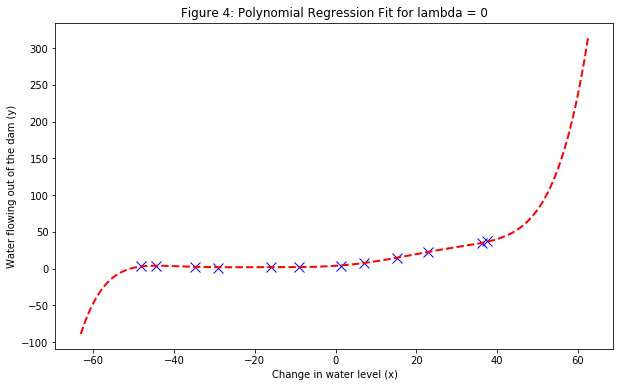

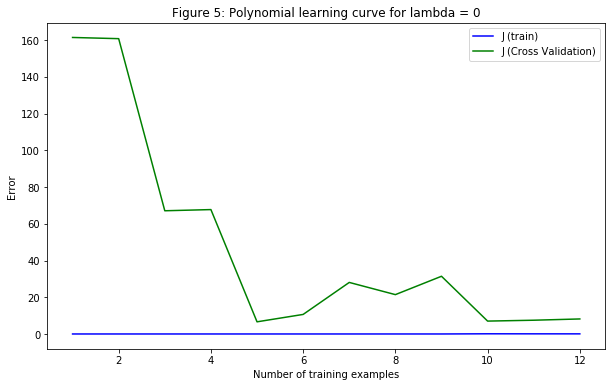

In [22]:
# lets plot the results
def plotFit(minX, maxX, mu, sigma, theta, p):
    # Plots a learned polynomial regression fit over an existing figure.
    x = np.array(np.arange(minX - 15, maxX + 25, 0.05))
    # Map X values
    X_poly = polyFeatures(x, p)
    X_poly = X_poly - mu
    X_poly = X_poly / sigma
    # Add ones
    X_poly = np.insert(X_poly, 0, 1, axis = 1)
    plt.plot(x, np.dot(X_poly,theta), '--', color = 'red' , lw = 2)

plt.figure(figsize = (10,6))
plt.plot(X, y, 'bx', ms = 10)
plotFit(min(X), max(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title ('Figure 4: Polynomial Regression Fit for lambda = {}'.format(regParam))

error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, 0)

plt.figure(figsize = (10,6))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title ('Figure 5: Polynomial learning curve for lambda = {}'.format(regParam))
plt.plot(range(1,X_poly.shape[0]+1), error_train, 'b', label='J (train)')
plt.plot(range(1,X_poly.shape[0]+1), error_val, 'g', label='J (Cross Validation)')
plt.legend(loc = 0)

Adding polynomial terms has perfectly fit the training set, but increase in polynomial terms can cause the problem of overfitting. This can be avoided by choosing the values of lambda (regParam) properly.

### Adjusting the Regularization Parameter

Lets plot the polynomial regression fit for lambda(regParam) = [1 and 100].

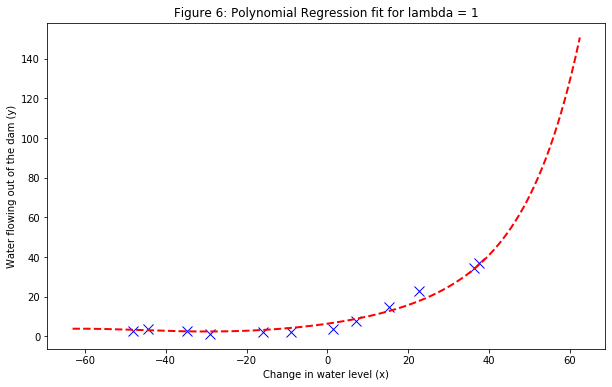

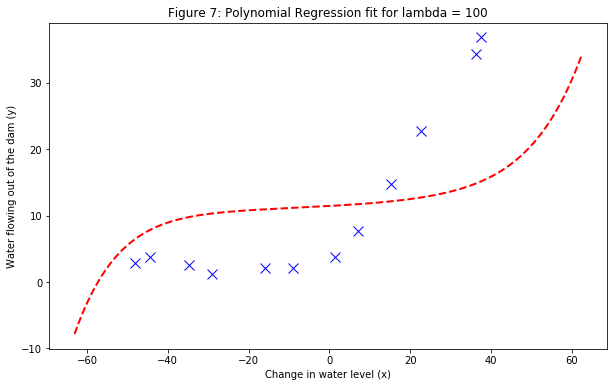

In [23]:
# Train linear regression with regParam = 1.
theta = trainLinearRegression(X_poly, y, 1)

plt.figure(figsize = (10, 6))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Figure 6: Polynomial Regression fit for lambda = 1')
plt.plot(X, y, 'bx', ms = 10)
plotFit(min(X), max(X), mu, sigma, theta, p)

# Train linear regression with regParam = 100.
theta = trainLinearRegression(X_poly, y, 100)

plt.figure(figsize = (10, 6))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Figure 7: Polynomial Regression fit for lambda = 100')
plt.plot(X, y, 'bx', ms = 10)
plotFit(min(X), max(X), mu, sigma, theta, p)

For λ=1, we see a polynomial fit that follows the data trend well (Figure 6). For λ=100, the polynomial fit (Figure 7) does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

### Selecting λ Using a Cross Validation Set

The value of λ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization (λ=0) fits the training set well, but does not generalize. Conversely, a model with too much regularization (λ=100) does not fit the training set and testing set well. A good choice of λ (e.g., λ=0) can provide a good fit to the data.

In this section, an automated method to select the λ parameter will be implemented. Concretely, a cross validation set will be used to evaluate how good each λ value is. After selecting the best λ value using the cross validation set, then the model can be evaluated on the test set to estimate how well the model will perform on actual unseen data.

In [24]:
def validationCurve(X, y, Xval, yval):
    """
    Generates the train and validation errors needed to plot a validation
    curve that can be used to select lambda.
    
    """
    # Create a list of 10 selected values of regParam.
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])

    # Initialize the errors.
    error_train = np.zeros((len(lambda_vec), 1))
    error_val = np.zeros((len(lambda_vec), 1))
    
    for i in range(len(lambda_vec)):
        regParam = lambda_vec[i]

        # Train the model with current regParam.
        theta = trainLinearRegression(X, y, regParam)

        # Compute the errors by setting lambda(regParam) = 0
        error_train[i] = linearRegCostFunction(X, y, theta, 0)[0]
        error_val[i] = linearRegCostFunction(Xval, yval, theta, 0)[0]
         
    return lambda_vec, error_train, error_val

In [25]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

			lambda	Train Error	Validation Error

			0.0	[0.06231714]	[8.18062442]

			0.001	[0.10856483]	[9.47219679]

			0.003	[0.16727677]	[16.03821519]

			0.01	[0.21802367]	[17.15028993]

			0.03	[0.27515866]	[13.21500013]

			0.1	[0.43866405]	[7.92668646]

			0.3	[0.86817063]	[4.76080449]

			1.0	[1.95869484]	[4.26335866]

			3.0	[4.52510481]	[3.83217638]

			10.0	[14.82580826]	[8.88972473]



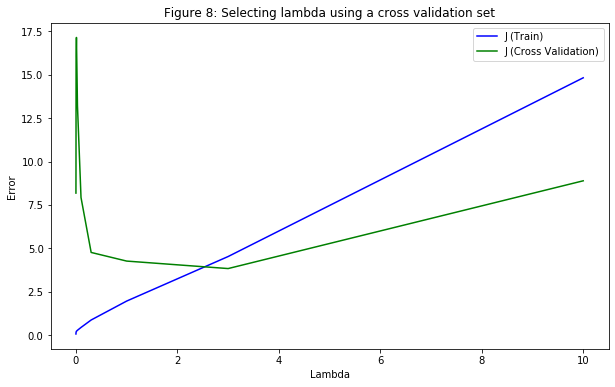

In [26]:
plt.figure(figsize = (10, 6))
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.title('Figure 8: Selecting lambda using a cross validation set')
plt.plot(lambda_vec, error_train, 'b', label='J (Train)')
plt.plot(lambda_vec, error_val, 'g', label='J (Cross Validation)')
plt.legend(loc = 0)

print('\t\t\tlambda\tTrain Error\tValidation Error\n')
for i in range(len(lambda_vec)):
    print('\t\t\t{}\t{}\t{}\n'.format(lambda_vec[i], error_train[i], error_val[i]))

From figure 8, it is clear that the best value of regParam at which the errors (training,cross validation)  coincide is 3.

### Computing Test Set Error

Lets apply the test set on the polynomial model with regParam = 3 and evaluate the test error!

In [27]:
# Train the model with the best value of lambda(regParam)
theta = trainLinearRegression(X_poly, y, 3)

# Get the test error with lambda(regParam) set to 0
error_test = linearRegCostFunction(X_poly_test, ytest, theta, 0)[0]
print('For lambda(regParam) = 3, the test error is {:f}'.format(float(error_test)))

For lambda(regParam) = 3, the test error is 3.572027
